In [2]:
!pip install language-tool-python

In [3]:
!pip install spacy textstat

!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.5 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
from scipy.sparse import hstack

import scipy.sparse as sp

In [2]:
import numpy as np

import pandas as pd

from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report



from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import torch

from sklearn.decomposition import PCA



import shap

import nltk

from nltk.tokenize import sent_tokenize



from transformers import BertTokenizer, BertModel


import textstat

import spacy

import language_tool_python

In [3]:
# Load the English language model

nlp = spacy.load("en_core_web_sm")



# Initialize the LanguageTool object for English

tool = language_tool_python.LanguageTool('en')

In [7]:

def vocalSize(sentence):

    # Tokenize with spaCy

    doc = nlp(sentence.lower())

    tokens = set([token.text for token in doc if not token.is_punct])



    # Get the vocabulary size

    vocab_size = len(tokens)

    # print(f"Vocabulary size: {vocab_size}")

    return vocab_size


In [10]:
# sentence = "Machine Learning is a way for computers to learn and make decisions without being explicitly programmed."

def sentence_complexity(sentence):

  flesch_score = textstat.flesch_reading_ease(sentence) # Flesch Reading Ease: Measures the readability of a sentence. Higher scores indicate easier readability.

  fk_grade_level = textstat.flesch_kincaid_grade(sentence) # Flesch-Kincaid Grade Level: Indicates the grade level required to understand the text. Higher scores mean more complex text.

  gunning_fog = textstat.gunning_fog(sentence) # Gunning Fog Index: Measures the readability of the text, considering sentence length and complex words (3+ syllables). Higher values indicate more complex text.

  smog_index = textstat.smog_index(sentence)  # SMOG Index: Estimates the years of education required to understand the text. Higher values indicate more complex text.



  composite_score = (flesch_score * 0.2 + fk_grade_level * 0.3 + gunning_fog * 0.3 + smog_index * 0.2)



  # print(f"Composite Sentence Complexity Score(In scale of 1 - 20): {composite_score}")

  return composite_score

In [11]:

def grammatical_mistakes(sentence):

  # Check for mistakes

  mistakes = len(tool.check(sentence))



  # Display the number of mistakes

  # print(f"Number of grammatical mistakes: {mistakes}")

  return mistakes




In [12]:
train_path = "/kaggle/input/xai-with-shap/test_set.csv"

test_path = "/kaggle/input/xai-with-shap/test_set.csv"

train_df = pd.read_csv(train_path)



In [14]:
test_df = pd.read_csv(test_path).sample(10)

In [13]:
train_df['vocab_size'] = train_df['text'].apply(vocalSize)

train_df['sentence_complexity'] = train_df['text'].apply(sentence_complexity)

train_df['grammatical_mistakes'] = train_df['text'].apply(grammatical_mistakes)

In [15]:
test_df['vocab_size'] = test_df['text'].apply(vocalSize)

test_df['sentence_complexity'] = test_df['text'].apply(sentence_complexity)

test_df['grammatical_mistakes'] = test_df['text'].apply(grammatical_mistakes)

In [16]:
# Vectorization

tfidf = TfidfVectorizer(max_features=25000)

X_tfidf = tfidf.fit_transform(train_df['text']).toarray()

y_train = train_df['label']



X_additional_features = train_df[['vocab_size', 'sentence_complexity', 'grammatical_mistakes']].to_numpy()



X_train = np.hstack((X_tfidf, X_additional_features))



# Initialize the classifier

xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)



# Fit the model

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

ROC AUC Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:
 [[5 0]
 [0 5]]


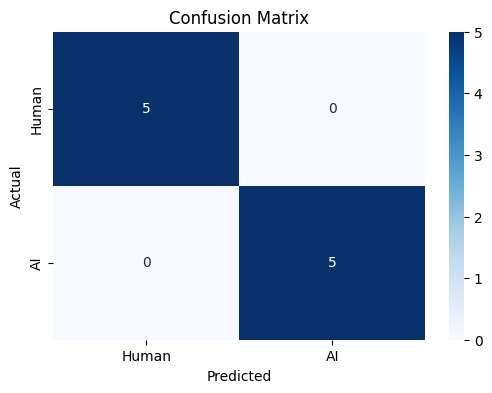

In [17]:
X_text_tfidf = tfidf.transform(test_df['text']).toarray()        # Transform testing text into TF-IDF features

y_test = test_df['label']



X_test_additional_features = test_df[['vocab_size', 'sentence_complexity', 'grammatical_mistakes']].to_numpy()



X_test = np.hstack((X_text_tfidf, X_test_additional_features))



# Predictions

y_pred = xgb_clf.predict(X_test)

y_proba = xgb_clf.predict_proba(X_test)[:, 1]



# Evaluation

roc_auc = roc_auc_score(y_test, y_proba)

print(f"ROC AUC Score: {roc_auc:.4f}")

print(classification_report(y_test, y_pred))



# Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)



# Plotting the Confusion Matrix

plt.figure(figsize=(6, 4))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.title('Confusion Matrix')

plt.show()

In [18]:
def model_predict(X_test):
    return xgb_clf.predict(X_test)

# Implementing SHAP

In [20]:
explainer = shap.KernelExplainer(model_predict, X_test)

In [25]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/10 [00:00<?, ?it/s]

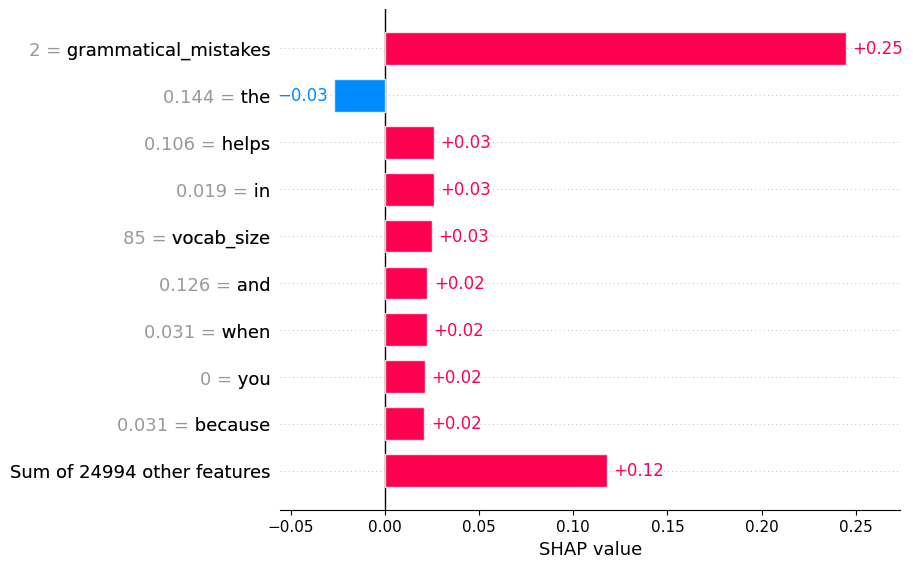

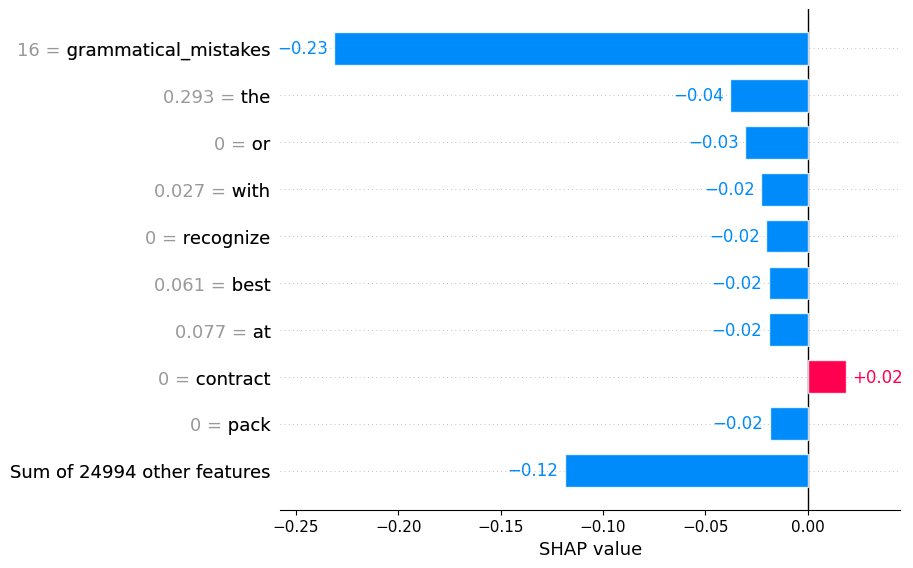

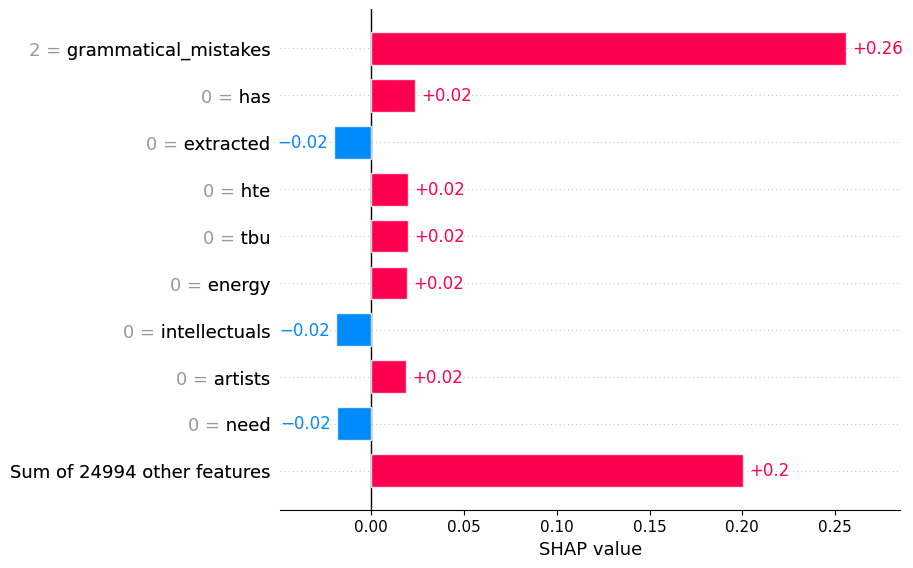

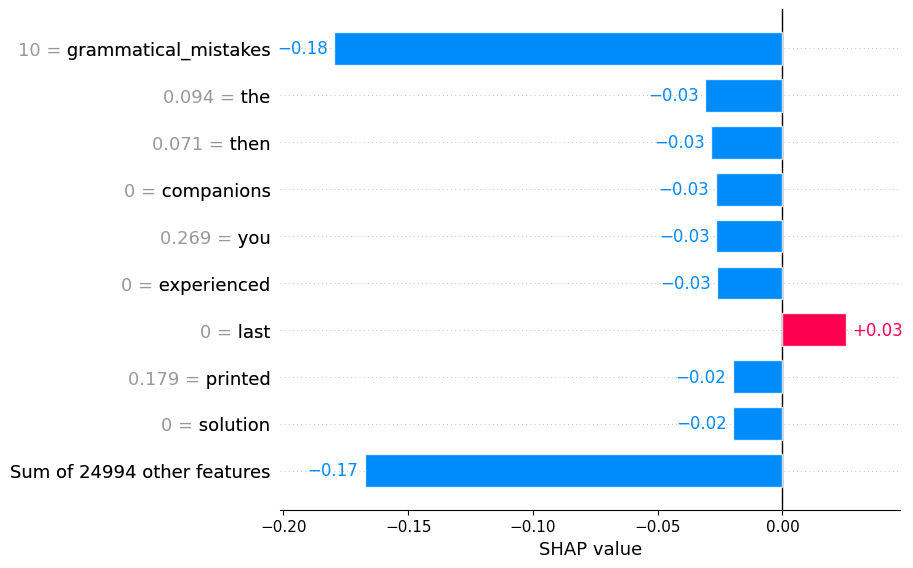

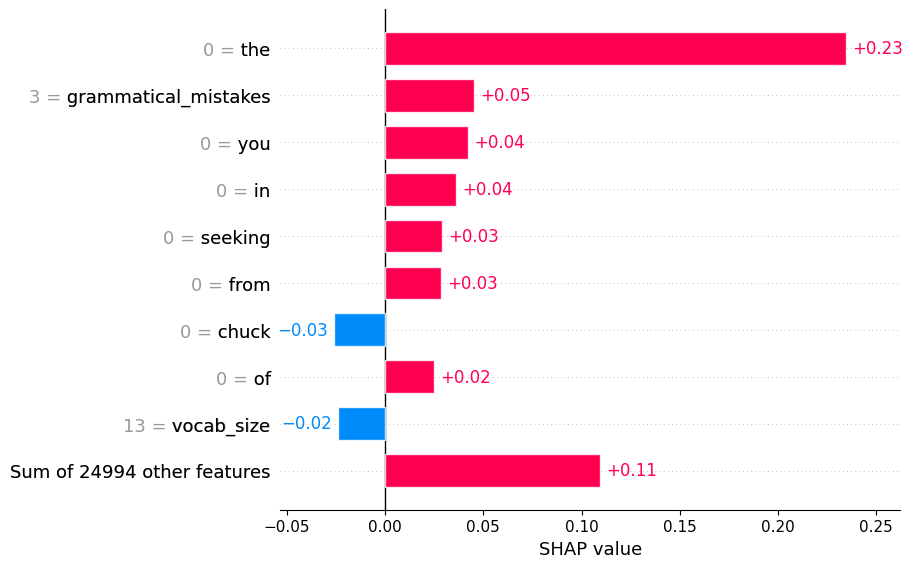

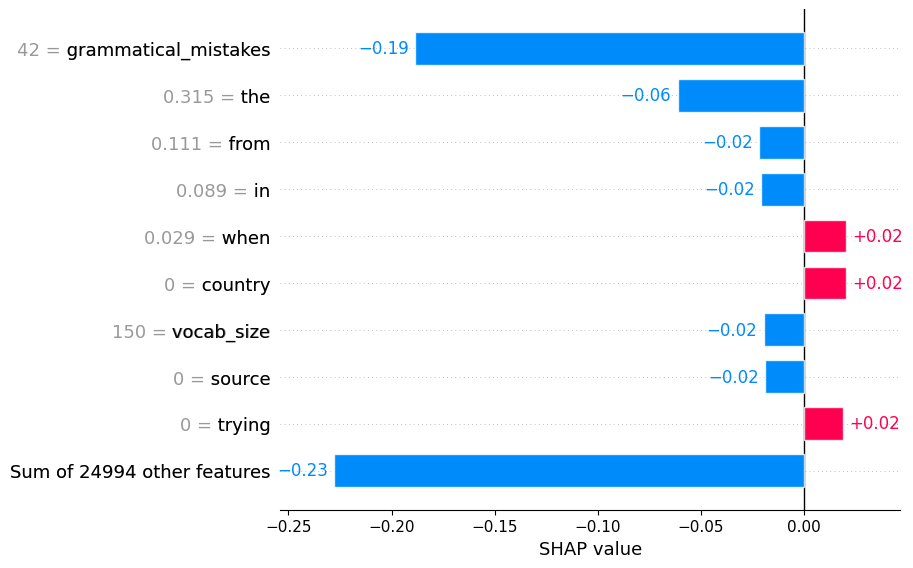

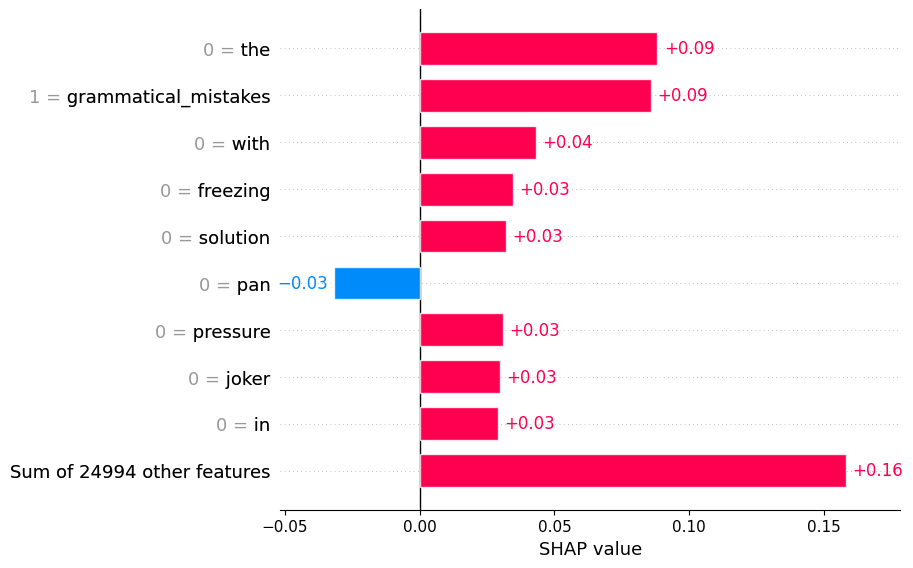

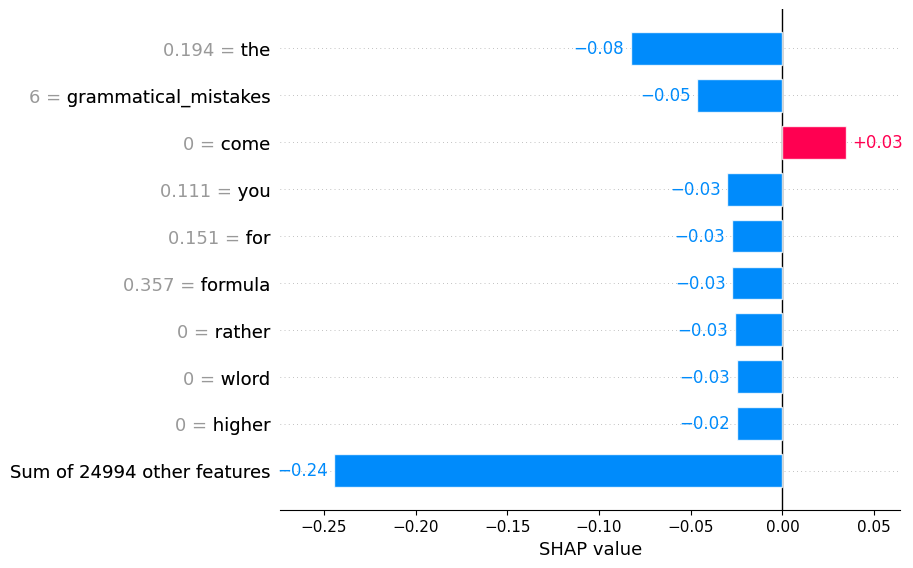

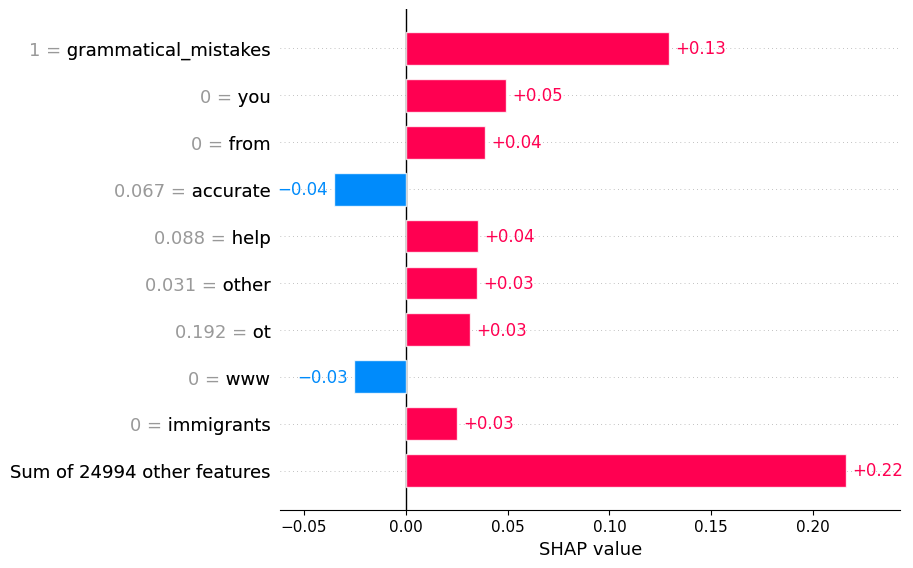

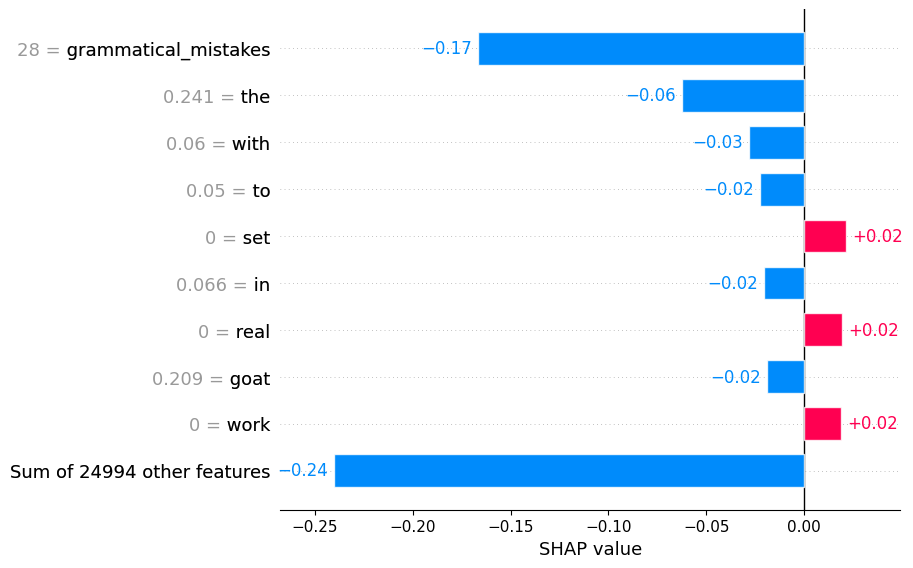

In [60]:
from shap import Explanation

for i in range(len(X_test)):
    explanation = shap.Explanation(
        values=shap_values[i],  # SHAP values for the i-th sample
        base_values=explainer.expected_value,  # Base value from the explainer
        data=X_test[i],  # Feature values of the i-th sample
        feature_names=tfidf.get_feature_names_out().tolist() + ['vocab_size', 'sentence_complexity', 'grammatical_mistakes']
    )
    shap.plots.bar(explanation)

In [75]:
def predict(new_sample):
    new_sample_tfidf = tfidf.transform(new_sample).toarray()
    sample_pred = xgb_clf.predict(new_sample_tfidf)
    sample_proba = xgb_clf.predict_proba(new_sample_tfidf)[:, 1]
    print(f"Predicted Label: {sample_pred[0]}")  # 1 for AI-generated, 0 for human-written
    print(f"Predicted Probability of being AI-generated: {sample_proba[0]:.4f}")

Dogs have a natural instinct not to view humans as food. Dogs are domesticated animals, which means they have been bred and raised by humans for thousands of years to be our companions, not our prey. Dogs are also social animals, and they are very attuned to the body language and behavior of the humans around them. When a dog sees a human, especially a baby, it will often recognize that the human is not acting like prey, but rather like a member of the pack or a caregiver. This helps the dog understand that the human is not something to be hunted or eaten. Additionally, dogs are often fed and cared for by humans, which helps to strengthen the bond between them and reinforces the idea that humans are not a source of food. In summary, dogs know that humans are not food because they have been domesticated to view humans as part of their pack and have learned through experience and social cues that humans are not something to be hunted or eaten.


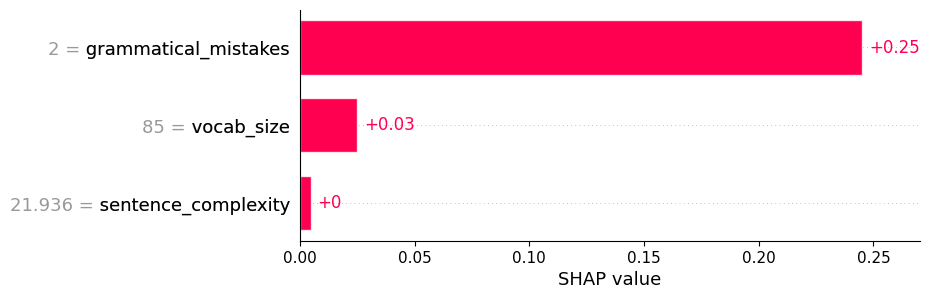

1 ) The educated and experienced do not need to use the exemptions that refugees get in order to immigrate to another country . They can use the normal immigration process . 2 ) Russia supports Assad who is the reason for many of the refugees fleeing in the first place . So a lot do not want to go there . 3 ) China has an overpopulation problem and so does not want immigrants . They are . At the first sign of troubles in a country tech companies and universities from around the world start recruiting the best and brightest . Especially the US have been very good at this . Even issuing green cards and other work permits without requiring the refugees to change citizenship so it will be easier to move and start a family . We have already seen the first intellectuals flee the US because of their policies . Both Russia and China are accepting these with open arms . There are no jobs as it is , do you really think they want their populations facing even more competition ?


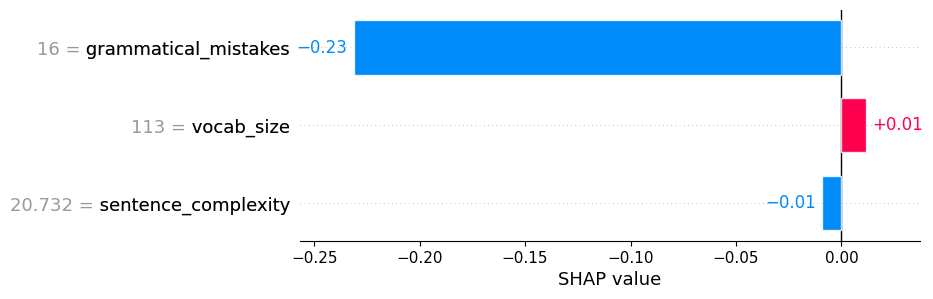

Rent seeking behavior is when people or organizations try to gain financial benefit by using their resources, such as money or influence, to get special privileges or advantages from the government or other organizations, rather than by producing goods or services. It's a way of trying to make money without contributing anything of value to society.

Here are a few examples of rent seeking behavior:

A company lobbies the government to pass a law that gives it a monopoly in a certain market, so it can charge higher prices without competition.

A group of farmers use their political connections to get a subsidy from the government , which pays them money even though they are not producing anything.

An organization uses its influence to get a contract from the government to build a bridge, even though there may be other companies that could do the job more cheaply.

A person uses their connections to get a job or promotion that they are not qualified for.

In general, rent seeking behav

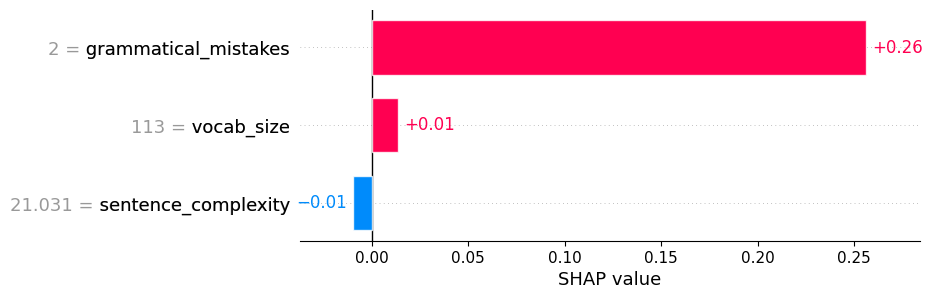

Remember that cards are printed in large sheets and then cut . If you want to make just 52 cards , your closest option to making them square is 4x13 . With 54 cards , you can print a 6x9 sheet which has much more manageable dimensions . Many decks these days are printed on 7x8 sheets giving you 56 cards in the pack . Jokers are used as wild cards in a huge number of games . URL_0 It was originally added for Euchre . It can also be used as replacement for a card that goes missing . If nothing else , if you end up losing another card you can write on the joker and boom another 5 of diamonds


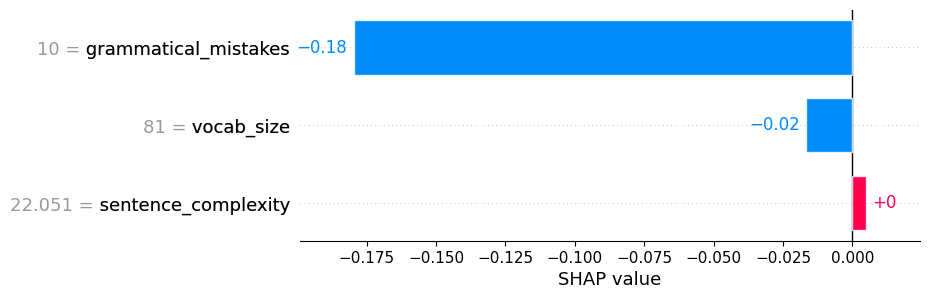

C VxVuV}0ÏU H»> »0u5 0 B»>3>}a» }x53UB0xVxa > B»5 3VUºU Vxu>Ïu5


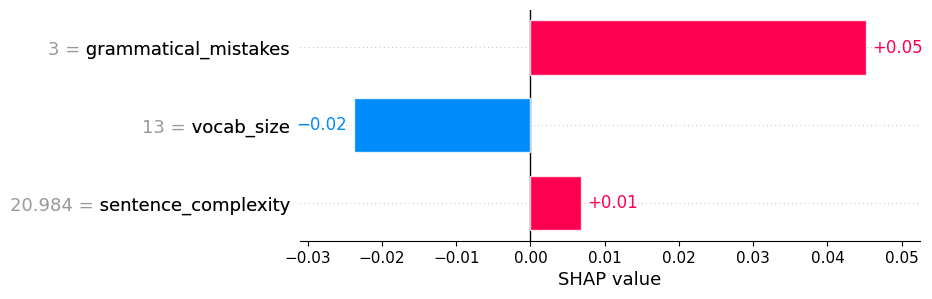

The fluid used in an AC unit turns into a liquid when under high pressure and back into a gas when under low pressure . the exchange from liquid to gas absorbs energy ( think you need to heat water to get it to boil ) and transforming from a gas to a liquid releases energy ( think freezing water into ice , you 're removing heat from the water by placing it in a cold area that absorbs the heat ) . So an AC unit has an evaporator coil inside the ductwork in your home . this is a low pressure area where the fluid is able to turn from liquid to gas . It pulls the heat out of the air in your ducts to get energy to transform from liquid to gas . This cools the air in the ducts , which gets pushed to the rooms in your house . The gas then travels to a compressor which puts the gas under a high pressure which will cause it to transform back into a liquid . This releases the heat to the surrounding air . This is done outside so the heat is just dumped into the surrounding air . The big boxy uni

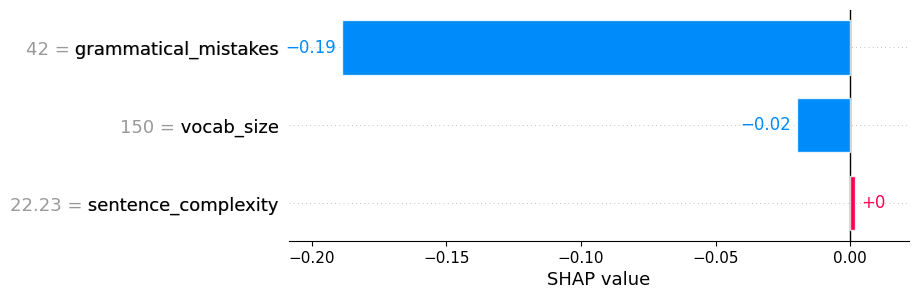

 0x VB'U 0ÏU> u53C >Ï


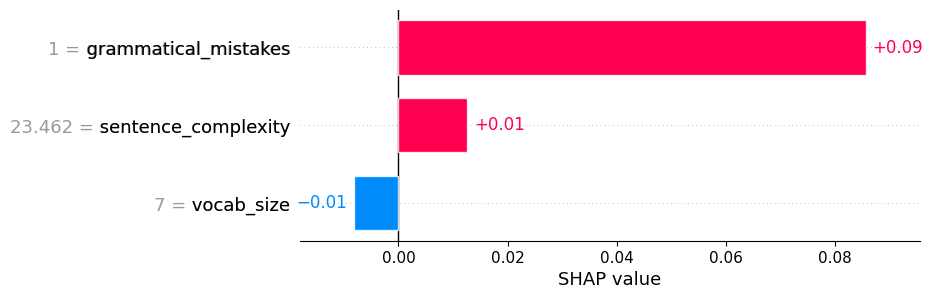

The solution is x = 8.92. This assumes that Chuck's six years of deposits start from today, so that the first deposit accumulates 10 years of gain, i.e. 20*(1 + 0.1)^10.  The second deposit gains nine years' interest: 20*(1 + 0.1)^9 and so on ...    If you want to do this calculation using the formula for an annuity due, i.e. http://www.financeformulas.net/Future-Value-of-Annuity-Due.html  where  (formula by induction) you have to bear in mind this is for the whole time span (k = 1 to n), so for just the first six years you need to calculate for all ten years then subtract another annuity calculation for the last four years.  So the full calculation is:  As you can see it's not very neat, because the standard formula is for a whole time span.  You could make it a little tidier by using a formula for k = m to n instead, i.e.  So the calculation becomes  which can be done with simple arithmetic (and doesn't actually need a solver).


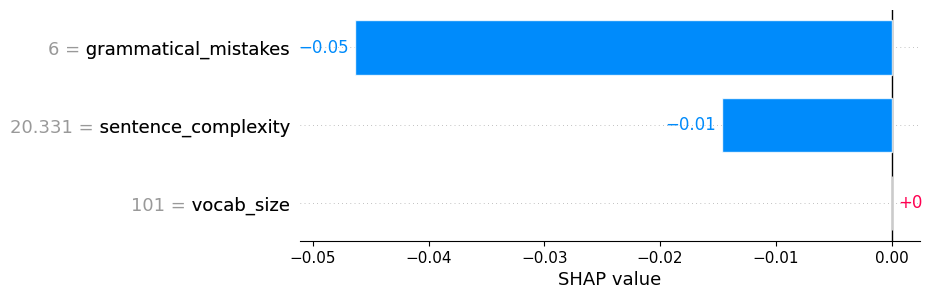

\nSeru! Siintfciec anti-realism is a ploociaphshil piotoisn that hlods that eth cepontcs and teoeirhs used ni scinece do ton cropronesd ot ahinntyg in the real world. In other words, sicnetific arlaetinis-ts bveeile taht teh sitifnceic dsoetrpincis of the world ear ufseul rfo pciernidtg dan elxpiinang phenomena, tbu tehy od not accurately rrneeepst the true nature of hte w.\\donAlnrn analogy ot help understand this cpncoet is to think about a map. A map si a reornesatpeitn of a particular plcae, btu ti si otn the pacle iftesl. tI is a simeiflipd version of the place that we can use to ntiaagve adn understand ti beetrt. Salriyiml, scientific treiohes and cctonpes aer lkie mpas fo teh wlord taht help su understand dan peridct what will hepapn in the wlrod, ubt they are tno the real world infle.ot\\Sns, ni spemlir temrs, scientific atinariesl-m si hte idea that eth thoreeis nad cptoencs that scientists esu to usarnntedd eth world aer just tools that hlep us mkae snsee fo thsgni, btu tehy 

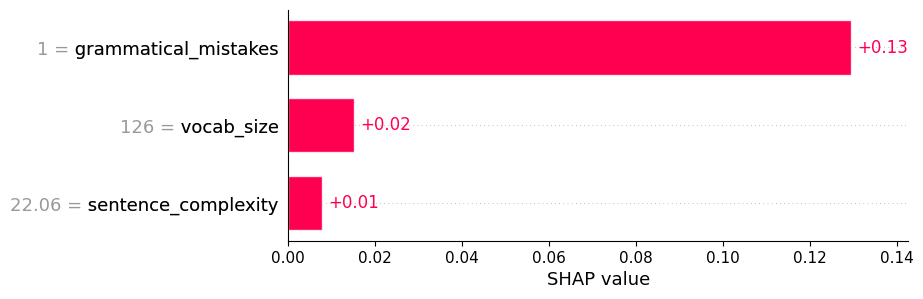

Pagan Mythology . When Christiandom became the dominant religion in Europe , anything associated with Europes religious past became considered " demonic " , " heretical " etc ... So the devil and demons were usually associated with previous deities of the former religion . The goat feet come from the greek god Pan , who was a Satyr and the son of Zeus . You are presumably asking about the Western Christian tradition of demons and Satan ? Their depictions are not consistent . For example , contrast the three - faced Satan frozen in ice in Dante 's Inferno with Amazon 's devil costumes . The goat - like features often attributed to Satan probably come from depictions of the Greek god Pan . But medieval depictions of Satan were as likely to show him with clawed feet as hooves . Basically when Satan or demons were first drawn or illuminated or woodcut the artists were just shooting for scary . Each artist has different influences . It should be noted that the New Testament never describes 

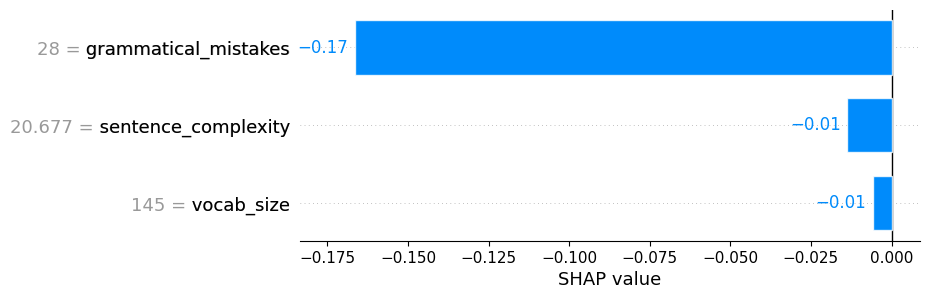

In [78]:
from shap import Explanation

# Specify the indices of the features you're interested in
selected_features = ['vocab_size', 'sentence_complexity', 'grammatical_mistakes']
selected_indices = [len(tfidf.get_feature_names_out()) + i for i, feature in enumerate(selected_features)]

# Loop through your test data
for i in range(len(X_test)):
    data = test_df.iloc[i]['text']
    print(data)
    # predict(str(data))
    explanation = shap.Explanation(
        values=shap_values[i][selected_indices],  # Only select SHAP values for the selected features
        base_values=explainer.expected_value,  # Base value from the explainer
        data=X_test[i][selected_indices],  # Feature values of the i-th sample
        feature_names=selected_features  # Only show selected feature names
    )
    shap.plots.bar(explanation)


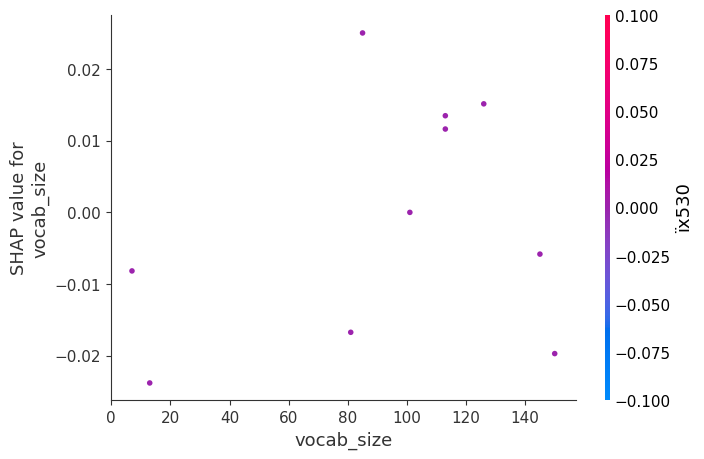

In [49]:
shap.dependence_plot('vocab_size', shap_values, X_test, 
                     feature_names=tfidf.get_feature_names_out().tolist() + ['vocab_size', 'sentence_complexity', 'grammatical_mistakes'])

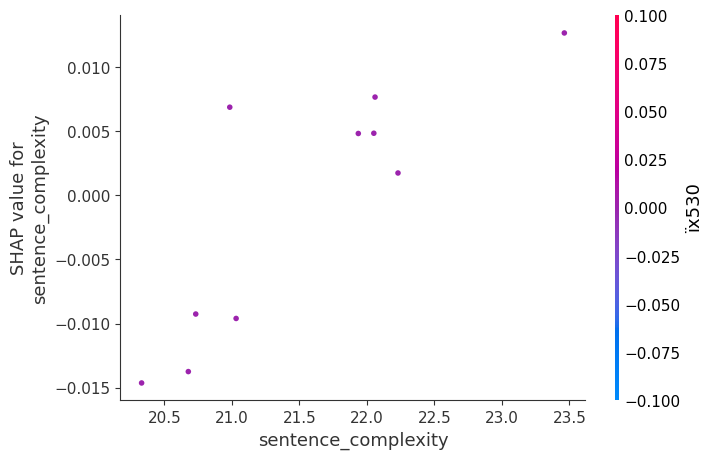

In [44]:
shap.dependence_plot('sentence_complexity', shap_values, X_test, feature_names=tfidf.get_feature_names_out().tolist() + ['vocab_size', 'sentence_complexity', 'grammatical_mistakes'])

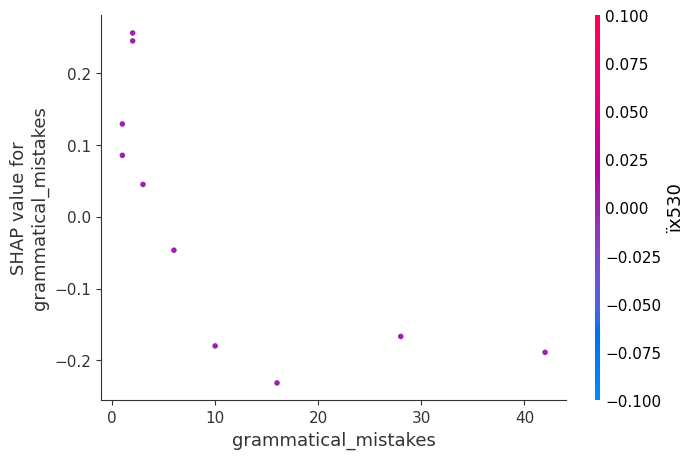

In [45]:
shap.dependence_plot('grammatical_mistakes', shap_values, X_test, feature_names=tfidf.get_feature_names_out().tolist() + ['vocab_size', 'sentence_complexity', 'grammatical_mistakes'])